<a href="https://colab.research.google.com/github/michelucci/oreilly-london-ai/blob/master/notebooks/Transfer_learning_with_keras_with_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Keras
## Using ```ImageGenerator```

(C) 2019 Umberto Michelucci

www.toelt.ai

Reference: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

In [0]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [0]:
import numpy as np
import os
import shutil

np.random.seed(42)

In [0]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

## Load the data

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes. [Source of the next few cells: google]

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-09-11 14:33:04--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 2607:f8b0:4001:c0f::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   175MB/s    in 0.4s    

2019-09-11 14:33:04 (175 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [6]:
!ls /tmp

cats_and_dogs_filtered	cats_and_dogs_filtered.zip


The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets , which in turn each contain `cats` and `dogs` subdirectories. Let's define each of these directories:

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [8]:
train_cat_fnames = os.listdir(train_cats_dir)
print (train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print (train_dog_fnames[:10])

['cat.949.jpg', 'cat.388.jpg', 'cat.308.jpg', 'cat.881.jpg', 'cat.193.jpg', 'cat.51.jpg', 'cat.653.jpg', 'cat.89.jpg', 'cat.398.jpg', 'cat.470.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [9]:
print ('total training cat images:', len(os.listdir(train_cats_dir)))
print ('total training dog images:', len(os.listdir(train_dogs_dir)))
print ('total validation cat images:', len(os.listdir(validation_cats_dir)))
print ('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [10]:
cat_train = os.listdir(train_cats_dir)
dog_train = os.listdir(train_dogs_dir)
cat_val = os.listdir(validation_cats_dir)
dog_val = os.listdir(validation_dogs_dir)

# Example: let's print the name of some of the files
print(cat_train[0:3])

['cat.949.jpg', 'cat.388.jpg', 'cat.308.jpg']


In [11]:
!ls /tmp/cats_and_dogs_filtered/train

cats  dogs


Let's write the files in separate folders... So we don't have to worry and do that again

In [0]:
train_dir = '/tmp/cats_and_dogs_filtered/train'
val_dir = '/tmp/cats_and_dogs_filtered/validation'

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# CNN Model

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
__________________________________________

In [16]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/10
100/100 - 10s - loss: 0.4871 - acc: 0.7725 - val_loss: 0.5454 - val_acc: 0.7350
Epoch 2/10
100/100 - 10s - loss: 0.4013 - acc: 0.8230 - val_loss: 0.5876 - val_acc: 0.7470
Epoch 3/10
100/100 - 10s - loss: 0.3552 - acc: 0.8660 - val_loss: 0.8399 - val_acc: 0.6810
Epoch 4/10
100/100 - 10s - loss: 0.2442 - acc: 0.8955 - val_loss: 0.8238 - val_acc: 0.6970
Epoch 5/10
100/100 - 10s - loss: 0.1579 - acc: 0.9415 - val_loss: 0.8872 - val_acc: 0.7170
Epoch 6/10
100/100 - 10s - loss: 0.1090 - acc: 0.9630 - val_loss: 1.0438 - val_acc: 0.7130
Epoch 7/10
100/100 - 10s - loss: 0.0870 - acc: 0.9695 - val_loss: 1.5000 - val_acc: 0.7150
Epoch 8/10
100/100 - 10s - loss: 0.0620 - acc: 0.9855 - val_loss: 1.7335 - val_acc: 0.7250
Epoch 9/10
100/100 - 10s - loss: 0.0705 - acc: 0.9800 - val_loss: 1.6163 - val_acc: 0.7110
Epoch 10/10
100/100 - 10s - loss: 0.0588 - acc: 0.9840 - val_loss: 1.5175 - val_acc: 0.7330


Note that we are extremly overfitting here! Check how the training accuracy is almost 100% while the validation accuracy is around 73%. Overfitting is typically one of the main problems when training big neural networks.

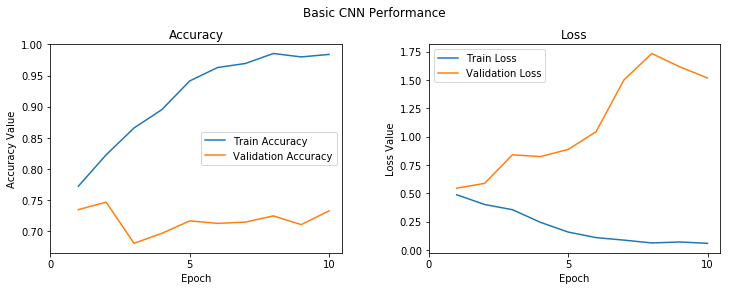

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,10+1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 10+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 10+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
input_shape = (150, 150, 3)

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.backend import clear_session

clear_session()

base_model=vgg16.VGG16(include_top=False, weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
preds=Dense(1,activation='sigmoid')(x)
model=Model(inputs=base_model.input,outputs=preds)

In [43]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

As you may notice all parameters are still trainable. We need to correct this.

In [0]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [47]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/10
100/100 - 20s - loss: 0.4549 - acc: 0.7910 - val_loss: 0.3064 - val_acc: 0.8640
Epoch 2/10
100/100 - 19s - loss: 0.3325 - acc: 0.8595 - val_loss: 0.2854 - val_acc: 0.8770
Epoch 3/10
100/100 - 19s - loss: 0.2817 - acc: 0.8800 - val_loss: 0.3990 - val_acc: 0.8210
Epoch 4/10
100/100 - 19s - loss: 0.2665 - acc: 0.8870 - val_loss: 0.2772 - val_acc: 0.8720
Epoch 5/10
100/100 - 19s - loss: 0.2499 - acc: 0.8955 - val_loss: 0.3910 - val_acc: 0.8410
Epoch 6/10
100/100 - 19s - loss: 0.2341 - acc: 0.9005 - val_loss: 0.2833 - val_acc: 0.8830
Epoch 7/10
100/100 - 19s - loss: 0.2212 - acc: 0.9040 - val_loss: 0.3015 - val_acc: 0.8670
Epoch 8/10
100/100 - 19s - loss: 0.2044 - acc: 0.9140 - val_loss: 0.2763 - val_acc: 0.8890
Epoch 9/10
100/100 - 19s - loss: 0.1780 - acc: 0.9270 - val_loss: 0.2917 - val_acc: 0.8830
Epoch 10/10
100/100 - 19s - loss: 0.1700 - acc: 0.9325 - val_loss: 0.3010 - val_acc: 0.8770
